Descripción:

En el siguiente problema, se presenta un conjunto de datos médicos de distintos pacientes. El objetivo es determinar si el paciente padece o no de diabetes en base a ciertos indicadores médicos. Todos los pacientes del dataset son de sexo femenino.

Dataset:

El dataset proporcionado incluye las siguientes variables para cada paciente:

Embarazos: Número de veces embarazada

Glucosa: Concentración de glucosa en plasma a las 2 horas en una prueba de tolerancia oral a la glucosa

Presión arterial: Presión arterial diastólica (mm Hg)

Espesor de la piel: Espesor del pliegue cutáneo del tríceps (mm)

Insulina: Insulina sérica a las 2 horas (mu U/ml)

IMC: Índice de masa corporal (peso en kg/(altura en m)^2)

Función de pedigree de la diabetes: Valor que evalúa la probabilidad de diabetes basada en antecedentes familiares.

Edad: Edad (años)

Resultado: variable objetivo (0 para diabetes negativo, 1 para positivo).

Objetivo:

Utilizando el dataset construido, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda predecir con precisión si el paciente en cuestión posee o no diabetes. Se debe entrenar y evaluar el modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

Entrega:

La entrega debe incluir:
Código fuente de la solución implementada en Google Colab, que incluya:
Análisis previo y preprocesamiento del set de datos.
Definición y entrenamiento del modelo.
Resultados de la evaluación del modelo, incluyendo métricas de desempeño y visualizaciones relevantes.
Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.


In [1]:
!pip install -q gdown

In [2]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, make_scorer
import optuna
from sklearn.compose import ColumnTransformer
import gdown
from keras import regularizers

In [ ]:
# TP1-2-diabetes.zip
gdown.download('https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_')

Downloading...
From: https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_
To: /content/TP1-2-diabetes.zip
100%|██████████| 9.13k/9.13k [00:00<00:00, 17.5MB/s]


'TP1-2-diabetes.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('TP1-2-diabetes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-2')

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

In [ ]:
df = pd.read_csv('TP1-2/diabetes.csv')

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


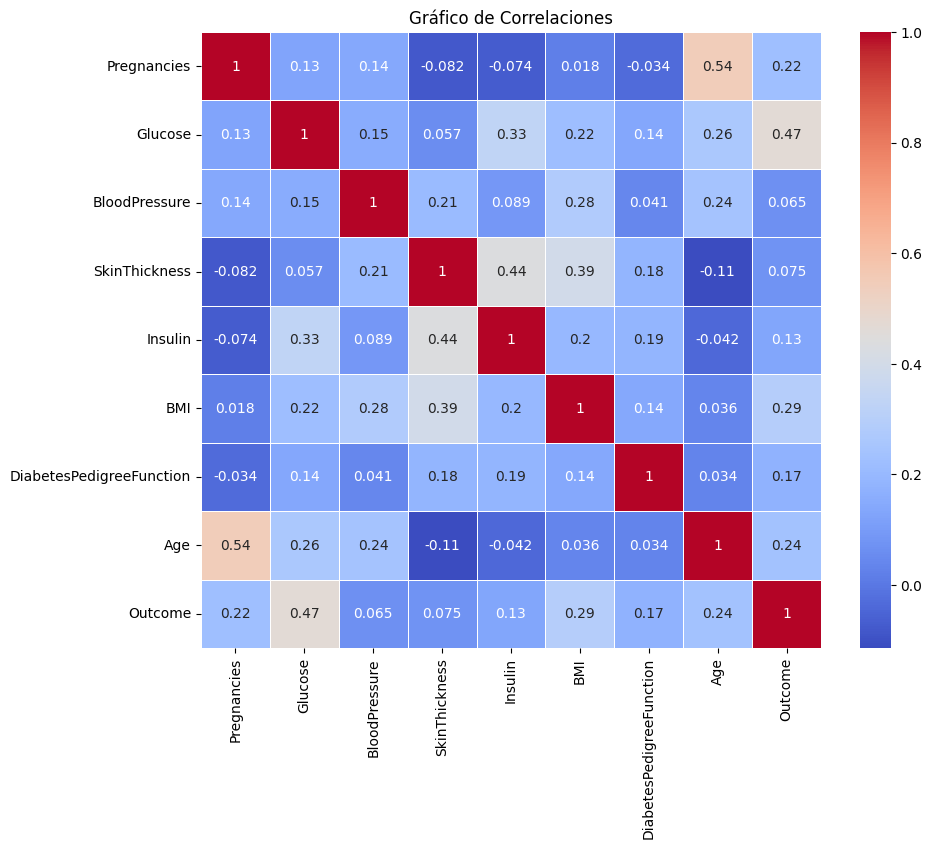

In [ ]:
# Calcula la matriz de correlación
correlation_matrix = df.corr()

# Creo un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Gráfico de Correlaciones")

plt.show()

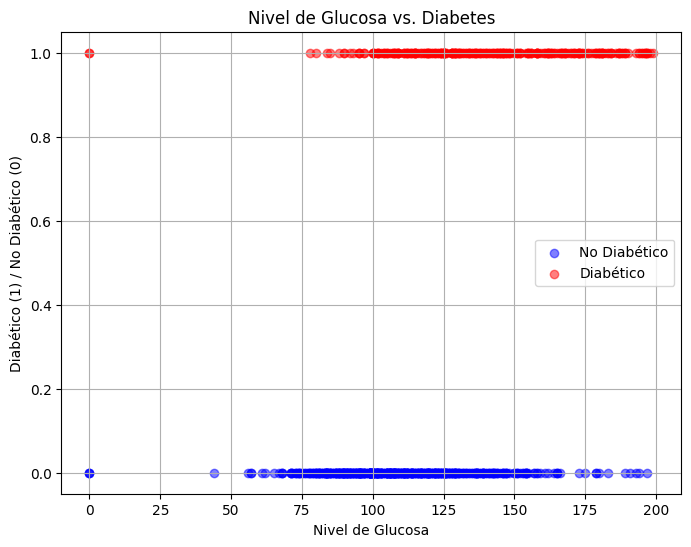

In [ ]:
# Filtrar los datos por Outcome (diabético o no diabético)
diabetes = df[df['Outcome'] == 1]
no_diabetes = df[df['Outcome'] == 0]

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(no_diabetes['Glucose'], no_diabetes['Outcome'], color='blue', alpha=0.5, label='No Diabético')
plt.scatter(diabetes['Glucose'], diabetes['Outcome'], color='red', alpha=0.5, label='Diabético')

# Etiquetas y título
plt.xlabel('Nivel de Glucosa')
plt.ylabel('Diabético (1) / No Diabético (0)')
plt.title('Nivel de Glucosa vs. Diabetes')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

<ipython-input-22-68684b1262f7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y='Glucose', data=df, palette='muted')


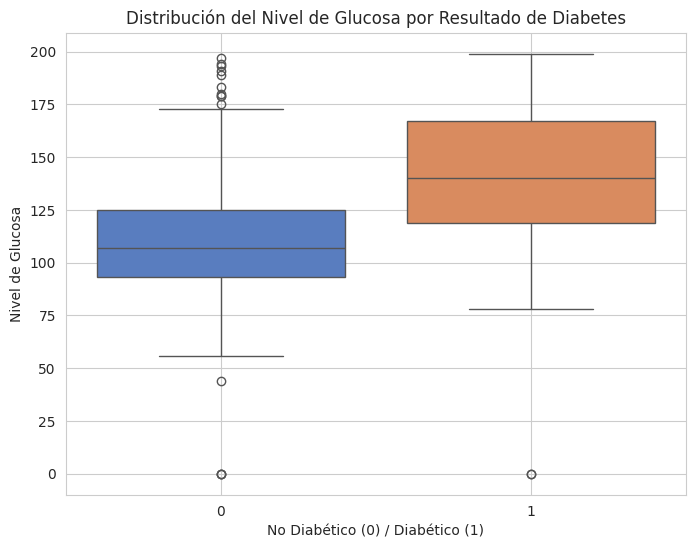

In [ ]:
# Configurar el estilo de seaborn
sns.set_style("whitegrid")

# Crear el gráfico de violín
plt.figure(figsize=(8, 6))
sns.boxplot(x='Outcome', y='Glucose', data=df, palette='muted')

# Etiquetas y título
plt.xlabel('No Diabético (0) / Diabético (1)')
plt.ylabel('Nivel de Glucosa')
plt.title('Distribución del Nivel de Glucosa por Resultado de Diabetes')

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [ ]:
X = df.drop(columns=["Outcome"])
y_clas = df["Outcome"]

X_train_clas, X_test_clas, y_train_clas, y_test_clas = train_test_split(X, y_clas, test_size=0.2, random_state=42)

In [ ]:
# Utilizamos el método StandardScaler de Scikit-Learn para estandarizar las variables
scaler = StandardScaler()

# Ajustar el scaler en el conjunto de entrenamiento y transformar tanto el conjunto de entrenamiento como el de prueba
X_train_clas_scaled = scaler.fit_transform(X_train_clas)
X_test_clas_scaled = scaler.transform(X_test_clas)

# Convertir los arrays NumPy de vuelta en DataFrames manteniendo los índices y las columnas
X_train_clas_scaled_df = pd.DataFrame(X_train_clas_scaled, index=X_train_clas.index, columns=X_train_clas.columns)
X_test_clas_scaled_df = pd.DataFrame(X_test_clas_scaled, index=X_test_clas.index, columns=X_test_clas.columns)

In [ ]:
def f1_score_(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum(tf.cast(tf.clip_by_value(y_pred - y_true, 0, 1), 'float32'))
    fn = tf.reduce_sum(tf.cast(tf.clip_by_value(y_true - y_pred, 0, 1), 'float32'))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1_score = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1_score

In [ ]:
model1 = Sequential([
    Input(shape=(X_train_clas_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='softmax')
])

model1.summary()

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Entrenamiento del modelo
model1.fit(X_train_clas_scaled, y_train_clas, epochs=100, batch_size=128, validation_data=(X_test_clas_scaled, y_test_clas))

# Realizar predicciones sobre el conjunto de prueba
predictions = model1.predict(X_test_clas_scaled)

# Crear un DataFrame con los valores reales y predichos
df_results = pd.DataFrame({'Real': y_test_clas, 'Predicho': predictions.flatten()})

# Mostrar los primeros 10 registros para verificar
print(df_results.head(20))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                288       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833 (3.25 KB)
Trainable params: 833 (3.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 1s 48ms/step - loss: 0.6846 - accuracy: 0.3469 - val_loss: 0.6736 - val_accuracy: 0.3571
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 0.6604 - accuracy: 0.3469 - val_loss: 0.6579 - val_accuracy: 0.3571
Epoch 3/

In [ ]:
model2 = Sequential([
    Input(shape=(X_train_clas_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='softmax')
])

model2.summary()

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Entrenamiento del modelo
model2.fit(X_train_clas_scaled, y_train_clas, epochs=100, batch_size=128, validation_data=(X_test_clas_scaled, y_test_clas))

# Realizar predicciones sobre el conjunto de prueba
predictions1 = model2.predict(X_test_clas_scaled)

# Crear un DataFrame con los valores reales y predichos
df_results1 = pd.DataFrame({'Real': y_test_clas, 'Predicho': predictions1.flatten()})

# Mostrar los primeros 10 registros para verificar
print(df_results1.head(20))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                576       
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 1s 51ms/step - loss: 0.6908 - accuracy: 0.3469 - val_loss: 0.6825 - val_accuracy: 0.3571
Epoch 2/100


#Optimizacion de Hiperparametros

In [ ]:
# Función de objetivo para clasificación
def objective_clas(trial):
    # Obtener los valores sugeridos por Optuna
    units = trial.suggest_int('units', 16, 64)
    activation_hidden = trial.suggest_categorical('activation_hidden', ['relu', 'tanh', 'sigmoid'])
    activation_output = trial.suggest_categorical('activation_output', ['sigmoid', 'softmax'])

    # Crear un nuevo modelo con los hiperparámetros sugeridos
    nuevo_modelo_clas = Sequential()
    nuevo_modelo_clas.add(Dense(units, input_shape=(8,), activation=activation_hidden))
    nuevo_modelo_clas.add(Dense(units=1, activation=activation_output))

    # Compilar y entrenar el modelo
    nuevo_modelo_clas.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_])
    nuevo_modelo_clas.fit(X_train_clas_scaled, y_train_clas, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Realizar predicciones en los datos de prueba
    y_prob_clas = nuevo_modelo_clas.predict(X_test_clas_scaled)
    y_pred_clas = (y_prob_clas > 0.5).astype(int)

    # Calcular las métricas
    accuracy_clas = accuracy_score(y_test_clas, y_pred_clas)
    precision_clas = precision_score(y_test_clas, y_pred_clas)
    recall_clas = recall_score(y_test_clas, y_pred_clas)
    f1_clas = f1_score(y_test_clas, y_pred_clas)

    return 1.0 - accuracy_clas  # Optuna minimiza, así que usamos 1 - accuracy

# Crear el estudio de Optuna para clasificación
study_clas = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_clas.optimize(objective_clas, n_trials=10)

# Obtener los mejores hiperparámetros para clasificación
best_params_clas = study_clas.best_params

# Utilizar los mejores hiperparámetros para construir un nuevo modelo de clasificación
mejor_modelo_clas = Sequential()
mejor_modelo_clas.add(Dense(best_params_clas['units'], input_shape=(8,), activation=best_params_clas['activation_hidden']))
mejor_modelo_clas.add(Dense(units=1, activation=best_params_clas['activation_output']))

# Compilar y entrenar el modelo final
mejor_modelo_clas.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_])
mejor_modelo_clas.fit(X_train_clas_scaled, y_train_clas, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# Realizar predicciones en los datos de prueba
y_prob_clas_optuna = mejor_modelo_clas.predict(X_test_clas_scaled)
y_pred_clas_optuna = (y_prob_clas_optuna > 0.5).astype(int)

# Calcular las métricas finales
accuracy_final = accuracy_score(y_test_clas, y_pred_clas_optuna)
precision_final = precision_score(y_test_clas, y_pred_clas_optuna)
recall_final = recall_score(y_test_clas, y_pred_clas_optuna)
f1_final = f1_score(y_test_clas, y_pred_clas_optuna)

# Imprimir las métricas finales
print("\nScores finales del modelo de clasificación:")
print(f"Accuracy: {accuracy_final}")
print(f"Precisión: {precision_final}")
print(f"Recall: {recall_final}")
print(f"F1 Score: {f1_final}")

[I 2024-04-23 14:35:48,248] A new study created in memory with name: no-name-882cae0e-109f-4f8f-9014-238de0909e19


5/5 [==============================] - 0s 3ms/step


[I 2024-04-23 14:35:52,429] Trial 0 finished with value: 0.23376623376623373 and parameters: {'units': 34, 'activation_hidden': 'relu', 'activation_output': 'sigmoid'}. Best is trial 0 with value: 0.23376623376623373.


5/5 [==============================] - 0s 4ms/step


[I 2024-04-23 14:35:54,912] Trial 1 finished with value: 0.6428571428571428 and parameters: {'units': 18, 'activation_hidden': 'relu', 'activation_output': 'softmax'}. Best is trial 0 with value: 0.23376623376623373.


5/5 [==============================] - 0s 2ms/step


[I 2024-04-23 14:35:58,010] Trial 2 finished with value: 0.6428571428571428 and parameters: {'units': 56, 'activation_hidden': 'relu', 'activation_output': 'softmax'}. Best is trial 0 with value: 0.23376623376623373.


5/5 [==============================] - 0s 3ms/step


[I 2024-04-23 14:35:59,640] Trial 3 finished with value: 0.6428571428571428 and parameters: {'units': 37, 'activation_hidden': 'tanh', 'activation_output': 'softmax'}. Best is trial 0 with value: 0.23376623376623373.


5/5 [==============================] - 0s 3ms/step


[I 2024-04-23 14:36:01,665] Trial 4 finished with value: 0.2272727272727273 and parameters: {'units': 38, 'activation_hidden': 'relu', 'activation_output': 'sigmoid'}. Best is trial 4 with value: 0.2272727272727273.


5/5 [==============================] - 0s 3ms/step


[I 2024-04-23 14:36:03,814] Trial 5 finished with value: 0.2727272727272727 and parameters: {'units': 45, 'activation_hidden': 'sigmoid', 'activation_output': 'sigmoid'}. Best is trial 4 with value: 0.2272727272727273.


5/5 [==============================] - 0s 3ms/step


[I 2024-04-23 14:36:06,102] Trial 6 finished with value: 0.6428571428571428 and parameters: {'units': 30, 'activation_hidden': 'tanh', 'activation_output': 'softmax'}. Best is trial 4 with value: 0.2272727272727273.


5/5 [==============================] - 0s 3ms/step


[I 2024-04-23 14:36:08,150] Trial 7 finished with value: 0.6428571428571428 and parameters: {'units': 17, 'activation_hidden': 'relu', 'activation_output': 'softmax'}. Best is trial 4 with value: 0.2272727272727273.


5/5 [==============================] - 0s 2ms/step


[I 2024-04-23 14:36:09,747] Trial 8 finished with value: 0.2597402597402597 and parameters: {'units': 42, 'activation_hidden': 'tanh', 'activation_output': 'sigmoid'}. Best is trial 4 with value: 0.2272727272727273.


5/5 [==============================] - 0s 3ms/step


[I 2024-04-23 14:36:11,777] Trial 9 finished with value: 0.6428571428571428 and parameters: {'units': 45, 'activation_hidden': 'relu', 'activation_output': 'softmax'}. Best is trial 4 with value: 0.2272727272727273.


5/5 [==============================] - 0s 3ms/step

Scores finales del modelo de clasificación:
Accuracy: 0.7597402597402597
Precisión: 0.6956521739130435
Recall: 0.5818181818181818
F1 Score: 0.6336633663366337


In [ ]:
best_params_clas

{'units': 38, 'activation_hidden': 'relu', 'activation_output': 'sigmoid'}

In [ ]:
# Definir la arquitectura de la red neuronal con los hiperparámetros óptimos
mejor_modelo_clas1 = Sequential()
mejor_modelo_clas1.add(Dense(38, input_shape=(8,), activation='relu'))  # Capa oculta con 38 unidades y activación ReLU
mejor_modelo_clas1.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con activación sigmoide

# Resumen del modelo
mejor_modelo_clas.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 38)                342       
                                                                 
 dense_84 (Dense)            (None, 1)                 39        
                                                                 
Total params: 381 (1.49 KB)
Trainable params: 381 (1.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
mejor_modelo_clas1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Entrenamiento del modelo
history = mejor_modelo_clas1.fit(X_train_clas_scaled, y_train_clas, epochs=100, batch_size=128, validation_data=(X_test_clas_scaled, y_test_clas))

In [ ]:
# Realizar predicciones sobre el conjunto de prueba
predictions = mejor_modelo_clas1.predict(X_test_clas_scaled)

In [ ]:
# Crear un DataFrame con los valores reales y predichos
df_results = pd.DataFrame({'Real': y_test_clas, 'Predicho': predictions.flatten()})

# Mostrar los primeros 10 registros para verificar
print(df_results.head(20))

In [ ]:
# Plot the training history, accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')

Descripción:

En el siguiente problema, se presenta un conjunto de datos sobre diferentes variedades de frijoles secos. El objetivo es desarrollar un modelo de clasificación que pueda distinguir entre siete variedades registradas de frijoles secos, utilizando características como forma, tamaño, tipo y estructura. Se utilizó un sistema de visión por computadora para obtener imágenes de los granos de frijol y luego se llevó a cabo la segmentación y extracción de características para obtener un total de 16 atributos, incluidas 12 dimensiones y 4 formas.

Dataset:

El dataset proporcionado incluye las siguientes variables para cada paciente:

Area (A): El área de una zona de frijol y el número de píxeles dentro de sus límites.

Perimeter (P): La circunferencia del frijol se define como la longitud de su borde.

Major axis length (L): La distancia entre los extremos de la línea más larga que se puede dibujar desde un frijol.

Minor axis length (l): La línea más larga que se puede dibujar desde el frijol mientras está perpendicular al eje principal.

Eccentricity (Ec): Excentricidad de la elipse que tiene los mismos momentos que la región.

Convex area (C): Número de píxeles en el polígono convexo más pequeño que puede contener el área de una semilla de frijol.

Equivalent diameter (Ed): El diámetro de un círculo que tiene el mismo área que el área de una semilla de frijol.

Extent (Ex): La relación de los píxeles en el cuadro delimitador con respecto al área del frijol.

Solidity (S): También conocida como convexidad. La relación de los píxeles en la envoltura convexa con respecto a los que se encuentran en los frijoles.

Compactness (CO): Mide la redondez de un objeto: Ed/L.

ShapeFactor1 (SF1).

ShapeFactor2 (SF2).

ShapeFactor3 (SF3).

ShapeFactor4 (SF4).

Class: Seker, Barbunya, Bombay, Cali, Dermosan, Horoz y Sira.

Objetivo:

Utilizando el conjunto de datos proporcionado, el objetivo es construir un modelo de clasificación que pueda predecir con precisión la variedad de frijol seco basándose en las características mencionadas anteriormente. Se emplearán técnicas de aprendizaje automático, específicamente redes neuronales, para entrenar y evaluar el modelo.
Además, se requiere que el alumno calcule y agregue al conjunto de datos las
siguientes características:

Aspect ratio (K): Relación entre la longitud del eje mayor (L) y la longitud del eje menor (l) .

Roundness (R): Se debe calcular utilizando la fórmula (4piA)/(P^2).

Estas nuevas características calculadas se utilizarán como parte del conjunto de datos para el entrenamiento y evaluación del modelo de clasificación.

Entrega:

La entrega debe incluir:

Código fuente de la solución implementada en Google Colab, que incluya:
Análisis previo y preprocesamiento del set de datos.
Definición y entrenamiento del modelo.
Resultados de la evaluación del modelo, incluyendo métricas de desempeño y visualizaciones relevantes.
Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.


In [4]:
import zipfile

with zipfile.ZipFile('TP1-2-Dry-Bean-Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-2')

In [5]:
data = pd.read_csv('TP1-2/TP1-2-Dry-Bean-Dataset.csv')

In [7]:
data

,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,0.549812,28715,190.141097,0.763923,0.988856,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,0.411785,29172,191.272750,0.783968,0.984986,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,0.562727,29690,193.410904,0.778113,0.989559,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,0.498616,30724,195.467062,0.782681,0.976696,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,0.333680,30417,195.896503,0.773098,0.990893,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,0.765002,42508,231.515799,0.714574,0.990331,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,0.735702,42494,231.526798,0.799943,0.990752,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,0.734065,42569,231.631261,0.729932,0.989899,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,0.741055,42667,231.653248,0.705389,0.987813,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   Eccentricity     13611 non-null  float64
 5   ConvexArea       13611 non-null  int64  
 6   EquivDiameter    13611 non-null  float64
 7   Extent           13611 non-null  float64
 8   Solidity         13611 non-null  float64
 9   Compactness      13611 non-null  float64
 10  ShapeFactor1     13611 non-null  float64
 11  ShapeFactor2     13611 non-null  float64
 12  ShapeFactor3     13611 non-null  float64
 13  ShapeFactor4     13611 non-null  float64
 14  Class            13611 non-null  object 
dtypes: float64(12), int64(2), object(1)
memory usage: 1.6+ MB


In [6]:
# Agregar nuevas características 'Aspect ratio' (K) y 'Roundness' (R)
data['Aspect ratio'] = data['MajorAxisLength'] / data['MinorAxisLength']
data['Roundness'] = (4 * np.pi * data['Area']) / (data['Perimeter'] ** 2)

data

,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class,Aspect ratio,Roundness
0,28395,610.291,208.178117,173.888747,0.549812,28715,190.141097,0.763923,0.988856,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER,1.197191,0.958027
1,28734,638.018,200.524796,182.734419,0.411785,29172,191.272750,0.783968,0.984986,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER,1.097356,0.887034
2,29380,624.110,212.826130,175.931143,0.562727,29690,193.410904,0.778113,0.989559,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER,1.209713,0.947849
3,30008,645.884,210.557999,182.516516,0.498616,30724,195.467062,0.782681,0.976696,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER,1.153638,0.903936
4,30140,620.134,201.847882,190.279279,0.333680,30417,195.896503,0.773098,0.990893,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER,1.060798,0.984877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,0.765002,42508,231.515799,0.714574,0.990331,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON,1.552728,0.916603
13607,42101,757.499,281.576392,190.713136,0.735702,42494,231.526798,0.799943,0.990752,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON,1.476439,0.922015
13608,42139,759.321,281.539928,191.187979,0.734065,42569,231.631261,0.729932,0.989899,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON,1.472582,0.918424
13609,42147,763.779,283.382636,190.275731,0.741055,42667,231.653248,0.705389,0.987813,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON,1.489326,0.907906


In [ ]:
cols = data.columns

for col in cols:
    print("--------------------")
    print("Columna: ", col)
    print("Cantidad de valores nulos: ", data[col].isnull().sum())
    print("Cantidad de valores únicos: ", data[col].nunique())
    print("Tipo de dato: ", data[col].dtype)
    # Si no es numérica, continuar con la siguiente columna
    if data[col].dtype == "object":
        print("--------------------")
        continue
    # Si es una columna categórica, mostrar la cantidad de veces que aparece cada valor
    if data[col].nunique() < 10:
        print("Valores únicos: ", data[col].unique())
        print("Cantidad de veces que aparece cada valor: ", data[col].value_counts())
    else:
        # Si es una columna numérica, mostramos media, desvío estándar, mínimo, máximo...
        print("Media: ", data[col].mean())
        print("Desvío estándar: ", data[col].std())
        print("Mínimo: ", data[col].min())
        print("Máximo: ", data[col].max())
    print("--------------------")

--------------------
Columna:  Area
Cantidad de valores nulos:  0
Cantidad de valores únicos:  12011
Tipo de dato:  int64
Media:  53048.284549261625
Desvío estándar:  29324.095716881944
Mínimo:  20420
Máximo:  254616
--------------------
--------------------
Columna:  Perimeter
Cantidad de valores nulos:  0
Cantidad de valores únicos:  13351
Tipo de dato:  float64
Media:  855.283458599662
Desvío estándar:  214.28969589196143
Mínimo:  524.736
Máximo:  1985.37
--------------------
--------------------
Columna:  MajorAxisLength
Cantidad de valores nulos:  0
Cantidad de valores únicos:  13543
Tipo de dato:  float64
Media:  320.1418673032454
Desvío estándar:  85.69418595953206
Mínimo:  183.601165003839
Máximo:  738.860153481881
--------------------
--------------------
Columna:  MinorAxisLength
Cantidad de valores nulos:  0
Cantidad de valores únicos:  13543
Tipo de dato:  float64
Media:  202.2707140825082
Desvío estándar:  44.970091294555395
Mínimo:  122.512653450744
Máximo:  460.198496827

In [ ]:
data["Class"].value_counts()

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64

In [7]:
# Convertir la variable 'Class' en variables dummy
data_encoded = pd.get_dummies(data, columns=['Class'], drop_first=True)

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = data_encoded.drop(columns=['Class_SIRA'])  # Eliminamos una columna dummy para evitar la multicolinealidad
y = data_encoded['Class_SIRA']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)],
    remainder='passthrough'
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Verificar las dimensiones de los conjuntos de datos de entrenamiento y prueba escalados
print("Dimensiones de X_train_scaled:", X_train_scaled.shape)
print("Dimensiones de X_test_scaled:", X_test_scaled.shape)


Dimensiones de X_train_scaled: (10888, 21)
Dimensiones de X_test_scaled: (2723, 21)


In [8]:
X_train['Class_BOMBAY'] = X_train['Class_BOMBAY'].astype(int)
X_train['Class_CALI'] = X_train['Class_CALI'].astype(int)
X_train['Class_DERMASON'] = X_train['Class_DERMASON'].astype(int)
X_train['Class_HOROZ'] = X_train['Class_HOROZ'].astype(int)
X_train['Class_SEKER'] = X_train['Class_SEKER'].astype(int)

X_test['Class_BOMBAY'] = X_test['Class_BOMBAY'].astype(int)
X_test['Class_CALI'] = X_test['Class_CALI'].astype(int)
X_test['Class_DERMASON'] = X_test['Class_DERMASON'].astype(int)
X_test['Class_HOROZ'] = X_test['Class_HOROZ'].astype(int)
X_test['Class_SEKER'] = X_test['Class_SEKER'].astype(int)

y_train = y_train.astype(int)

y_test = y_test.astype(int)

In [ ]:
X_test

,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Compactness,...,ShapeFactor2,ShapeFactor3,ShapeFactor4,Aspect ratio,Roundness,Class_BOMBAY,Class_CALI,Class_DERMASON,Class_HOROZ,Class_SEKER
1488,42339,741.226,260.199331,207.306394,0.604347,42676,232.180294,0.771202,0.992103,0.892317,...,0.002403,0.796230,0.999383,1.255144,0.968387,0,0,0,0,1
2611,68247,1088.754,370.368146,237.863792,0.766507,70172,294.779204,0.767683,0.972567,0.795909,...,0.001343,0.633471,0.986352,1.557060,0.723492,0,0,0,0,0
749,37856,708.716,248.430330,194.360324,0.622835,38232,219.544429,0.744640,0.990165,0.883726,...,0.002469,0.780972,0.998235,1.278195,0.947109,0,0,0,0,1
99,33143,648.385,222.526310,189.737379,0.522480,33377,205.423899,0.769980,0.992989,0.923144,...,0.003008,0.852195,0.999465,1.172812,0.990685,0,0,0,0,1
11298,29925,647.570,237.714031,161.004848,0.735703,30321,195.196551,0.785309,0.986940,0.821140,...,0.002228,0.674271,0.995521,1.476440,0.896748,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,73100,1079.089,380.360015,245.418405,0.763991,74217,305.080007,0.794669,0.984950,0.802082,...,0.001328,0.643336,0.997070,1.549843,0.788883,0,0,0,0,0
532,36566,694.803,245.209088,190.102923,0.631632,36883,215.771354,0.778596,0.991405,0.879948,...,0.002480,0.774309,0.998762,1.289875,0.951840,0,0,0,0,1
10926,28412,623.016,227.308988,159.472066,0.712605,28735,190.198007,0.809505,0.988759,0.836738,...,0.002419,0.700130,0.997954,1.425384,0.919842,0,0,1,0,0
4676,74684,1046.993,398.943901,240.106668,0.798605,75767,308.367674,0.802553,0.985706,0.772960,...,0.001176,0.597467,0.992708,1.661528,0.856150,0,1,0,0,0


In [9]:
# Definir la arquitectura del modelo de red neuronal con dropout
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),  # Dropout del 20% para la capa oculta
    Dense(32, activation='relu'),
    Dropout(0.2),  # Dropout del 20% para la capa oculta
    Dense(16, activation='relu'),
    Dropout(0.2),  # Dropout del 20% para la capa oculta
    Dense(7, activation='softmax')  # 7 neuronas en la capa de salida para las 7 clases
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con dropout
history_dropout = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
273/273 [==============================] - 16s 24ms/step - loss: 0.5283 - accuracy: 0.8102 - val_loss: 0.0881 - val_accuracy: 0.9826
Epoch 2/50
273/273 [==============================] - 2s 7ms/step - loss: 0.0751 - accuracy: 0.9790 - val_loss: 0.0293 - val_accuracy: 0.9917
Epoch 3/50
273/273 [==============================] - 3s 10ms/step - loss: 0.0298 - accuracy: 0.9925 - val_loss: 0.0292 - val_accuracy: 0.9931
Epoch 4/50
273/273 [==============================] - 4s 15ms/step - loss: 0.0220 - accuracy: 0.9945 - val_loss: 0.0273 - val_accuracy: 0.9945
Epoch 5/50
273/273 [==============================] - 3s 10ms/step - loss: 0.0201 - accuracy: 0.9948 - val_loss: 0.0253 - val_accuracy: 0.9936
Epoch 6/50
273/273 [==============================] - 2s 7ms/step - loss: 0.0198 - accuracy: 0.9956 - val_loss: 0.0242 - val_accuracy: 0.9949
Epoch 7/50
273/273 [==============================] - 1s 4ms/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.0241 - val_accuracy: 0.9949
E

In [10]:
# Definir la arquitectura del modelo de red neuronal con dropout y regularización L2
model1 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),  # Dropout del 50% para la capa oculta
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),  # Dropout del 50% para la capa oculta
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),  # Dropout del 50% para la capa oculta
    Dense(7, activation='softmax')  # 7 neuronas en la capa de salida para las 7 clases
])

# Compilar el modelo
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con dropout y regularización L2
history_dropout_regularization = model1.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
273/273 [==============================] - 2s 3ms/step - loss: 0.8513 - accuracy: 0.7239 - val_loss: 0.3740 - val_accuracy: 0.8159
Epoch 2/50
273/273 [==============================] - 1s 2ms/step - loss: 0.4353 - accuracy: 0.8444 - val_loss: 0.2562 - val_accuracy: 0.9500
Epoch 3/50
273/273 [==============================] - 1s 3ms/step - loss: 0.2858 - accuracy: 0.9458 - val_loss: 0.1408 - val_accuracy: 0.9913
Epoch 4/50
273/273 [==============================] - 1s 3ms/step - loss: 0.1800 - accuracy: 0.9782 - val_loss: 0.1077 - val_accuracy: 0.9917
Epoch 5/50
273/273 [==============================] - 1s 4ms/step - loss: 0.1434 - accuracy: 0.9851 - val_loss: 0.1000 - val_accuracy: 0.9936
Epoch 6/50
273/273 [==============================] - 1s 3ms/step - loss: 0.1199 - accuracy: 0.9898 - val_loss: 0.0938 - val_accuracy: 0.9949
Epoch 7/50
273/273 [==============================] - 1s 2ms/step - loss: 0.1096 - accuracy: 0.9920 - val_loss: 0.0865 - val_accuracy: 0.9949
Epoch 

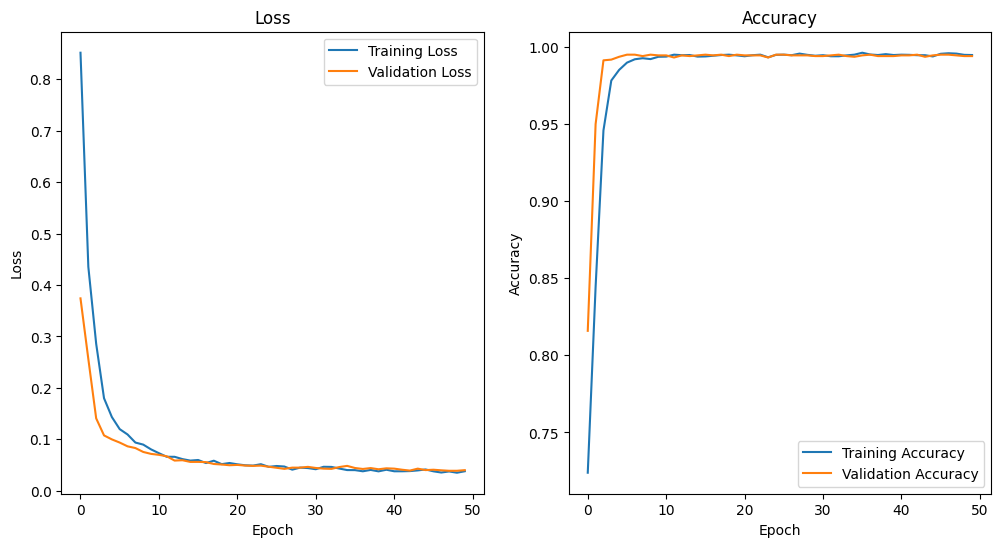

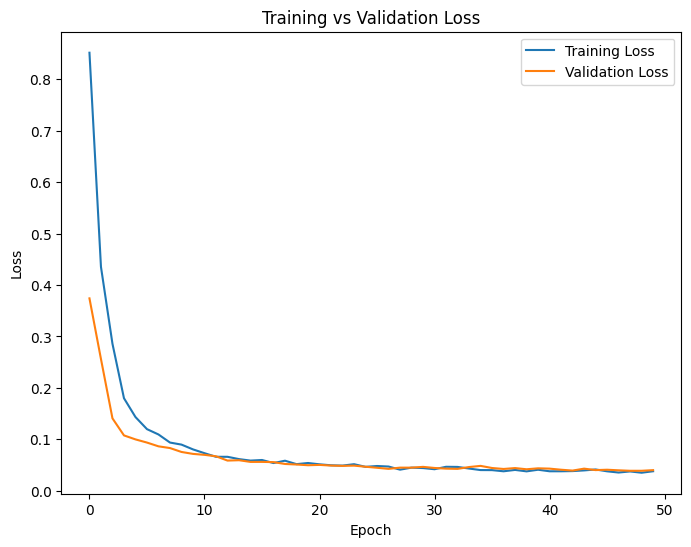

In [11]:
# 1. Graficar las Curvas de Pérdida y Precisión
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 6))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 2. Observar la Diferencia entre Pérdida de Entrenamiento y Pérdida de Validación
def plot_loss_difference(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Graficar las curvas de pérdida y precisión
plot_loss_accuracy(history_dropout_regularization)

# Observar la diferencia entre pérdida de entrenamiento y pérdida de validación
plot_loss_difference(history_dropout_regularization)

In [15]:
# Realizar predicciones en el conjunto de prueba
y_pred = model1.predict(X_test_scaled)

# Convertir las probabilidades en etiquetas de clase
y_pred_labels = np.argmax(y_pred, axis=1)

# Comparar las etiquetas predichas con las etiquetas reales
comparison_df = pd.DataFrame({'Real': y_test, 'Predicho': y_pred_labels})

# Imprimir las primeras filas del DataFrame para verificar
comparison_df


86/86 [==============================] - 0s 3ms/step


,Real,Predicho
1488,0,0
2611,0,0
749,0,0
99,0,0
11298,0,0
...,...,...
2884,0,0
532,0,0
10926,0,0
4676,0,0
